In [50]:
from portraitnet import PortraitNet
from portrait_datasets import PortraitDataset
import yaml, torch, cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [51]:
class DictAsObject:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, DictAsObject(value))
            else:
                setattr(self, key, value)

with open('./config.yaml') as f:
    args = yaml.full_load(f.read())
    args = DictAsObject(args)

In [52]:
model = PortraitNet(addEdge=True).to(args.device)
# trained_path = "/workspace/liangjuhao/teaching/PortraitNet/checkpoints/test/saved.pth"
# model.load_state_dict(torch.load(trained_path))
trained_best = "/workspace/liangjuhao/teaching/PortraitNet/checkpoints/test/model_best.pth.tar"
model.load_state_dict(torch.load(trained_best)['state_dict'])
test_dataset = PortraitDataset(args, split='test')
train_dataset = PortraitDataset(args, split='train')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


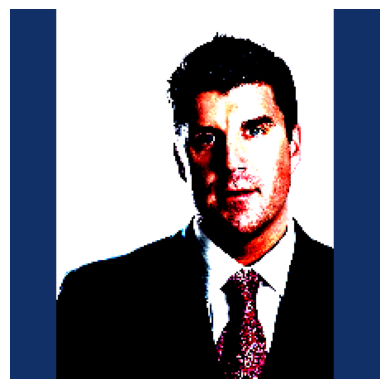

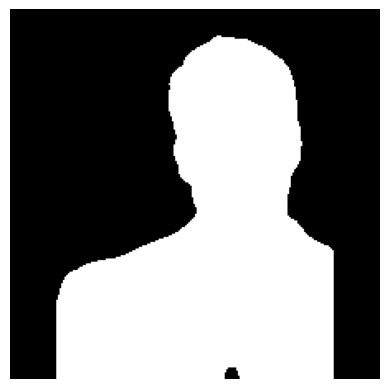

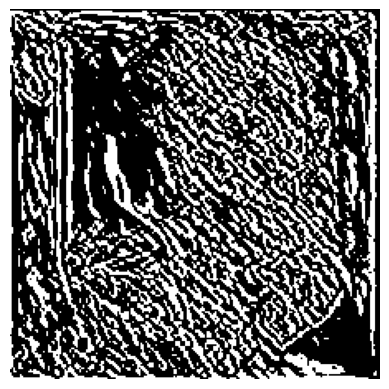

30280.0
8581.0
0.2833883751651255


In [53]:
def calcIOU(pred, mask):
    # sum1 = mask # recall
    sum1 = pred + mask
    sum1[sum1>0] = 1.0
    sum2 = pred + mask
    sum2[sum2<2] = 0.0
    sum2[sum2>=2] = 1.0
    if np.sum(sum1) == 0:
        return 1.0
    else:
        print(np.sum(sum1))
        print(np.sum(sum2))
        return 1.0*np.sum(sum2)/np.sum(sum1)

def show_image(image):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')  # 使用灰度颜色映射
    else:
        image = np.transpose(image, (1, 2, 0))
        image = image[...,::-1]
        plt.imshow(image)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

for input_ori, input, edge, mask in test_dataloader:
    input_var = input.to(args.device)
    mask_var = mask.to(args.device)
    output_mask, output_edge = model(input_var)
    output_mask = F.softmax(output_mask, dim=1)
    prob = output_mask[0,1,:,:]
    pred = prob.data.cpu().numpy()
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    show_image(input[0].numpy())
    show_image(mask[0].numpy())
    show_image(pred)
    print(calcIOU(pred, mask[0].numpy()))
    break

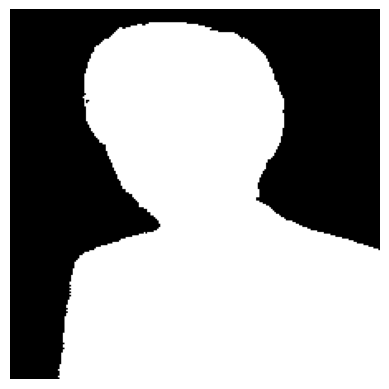

In [54]:
image_path = "/workspace/liangjuhao/teaching/PortraitNet/data/EG1800/Labels/00001.png"
image = cv2.imread(image_path, 0)
image[image>1] = 0
image = cv2.resize(np.uint8(image), (224, 224), interpolation=cv2.INTER_NEAREST)
image_array = np.array(image)
# print(image_array.shape)
show_image(image_array)